## This notebook is using a dataset *Glass Identification Database*

Dataset is available here:
https://github.com/oziomek1/ML.2018/blob/master/HomeworkNaiveBayes.ipynb

#### Structure of dataset:
1. Id number: 1 to 200
2. RI: refractive index 
3. Na: Sodium (unit measurement: weight percent in corresponding oxide, as are attributes 4-10) 
4. Mg: Magnesium 
5. Al: Aluminum 
6. Si: Silicon 
7. K: Potassium 
8. Ca: Calcium 
9. Ba: Barium 
10. Fe: Iron 
11. Type of glass: (class attribute), 1 for Glass, 2 for non-Glass windows

In [1]:
import pandas as pd
import numpy as np
import math
import os

print(os.listdir('datasets'))

['glass.csv', 'dataset_2.txt', 'dataset_1.txt', 'ign.csv', 'spam.csv']


In [2]:
data = pd.read_csv('datasets/glass.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 11 columns):
Id                 200 non-null int64
RefractiveIndex    200 non-null float64
Sodium             200 non-null float64
Magnesium          200 non-null float64
Aluminium          200 non-null float64
Silicon            200 non-null float64
Potassium          200 non-null float64
Calcium            200 non-null float64
Barium             200 non-null float64
Iron               200 non-null float64
GlassType          200 non-null int64
dtypes: float64(9), int64(2)
memory usage: 17.3 KB


In [3]:
data.head()

,Id,RefractiveIndex,Sodium,Magnesium,Aluminium,Silicon,Potassium,Calcium,Barium,Iron,GlassType
0,1,1.51824,12.87,3.48,1.29,72.95,0.60,8.43,0.00,0.00,1
1,2,1.51832,13.33,3.34,1.54,72.14,0.56,8.99,0.00,0.00,1
2,3,1.51747,12.84,3.50,1.14,73.27,0.56,8.55,0.00,0.00,1
3,4,1.51775,12.85,3.48,1.23,72.97,0.61,8.56,0.09,0.22,1
4,5,1.51768,12.65,3.56,1.30,73.08,0.61,8.69,0.00,0.14,1


In [4]:
from sklearn.model_selection import train_test_split
train_data = data.iloc[:, 1:10]
list(train_data)

['RefractiveIndex',
 'Sodium',
 'Magnesium',
 'Aluminium',
 'Silicon',
 'Potassium',
 'Calcium',
 'Barium',
 'Iron']

In [5]:
X_train,X_test,y_train,y_test = train_test_split(train_data, data["GlassType"], test_size = 0.2, random_state = 2018)

In [6]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(160, 9)
(40, 9)
(160,)
(40,)


### Check this model against built-in Gaussian Naive Bayes

In [7]:
from sklearn.naive_bayes import GaussianNB
prediction = dict()
clfGNB = GaussianNB()
clfGNB.fit(X_train, y_train)

GaussianNB(priors=None)

In [8]:
prediction['sklearnGNB'] = clfGNB.predict(X_test)

In [9]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, prediction['sklearnGNB'])

0.94999999999999996

### Built-in Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression
clfLR = LogisticRegression()
clfLR.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [11]:
prediction['sklearnLR'] = clfLR.predict(X_test)

In [12]:
accuracy_score(y_test, prediction['sklearnGNB'])

0.94999999999999996

### Now, let's try build naive bayes classifier myself and compare results

In [13]:
class GNBclassifier:
    def __init__(self):
        pass
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        self.prior()
        self.calculate_mean()
    
    def prior(self):
        counts = self.y.value_counts().to_dict()
        self.priors = {(k, v / len(self.X)) for k, v in counts.items()} 
    
    def calculate_mean(self):
        self.mean_variance = {}
        for c in self.y.unique():
            filtered_set = self.X[(self.y == c)]
            m_v = {}
            for name in self.X:
                m_v[name] = []
                m_v[name].append(filtered_set[name].mean())
                m_v[name].append(math.pow(filtered_set[name].std(), 2))
            self.mean_variance[c] = m_v
        
        
    def probability(self, x, mean, variance):
        exponent = math.exp(-(math.pow(x - mean, 2) / (2 * variance)))
        return (1 / (math.sqrt(2 * math.pi * variance))) * exponent
    
    def predict(self, X_test):
        self.X_test = X_test
        predictions = {}
        preds = list()
        iterator = 0
        for _, row in self.X_test.iterrows():
            results = {}
            for k, v in self.priors:
                p = 0
                for name in self.X:
                    prob = self.probability(row[name], 
                                            self.mean_variance[k][name][0],
                                            self.mean_variance[k][name][1])
                    if prob > 0:
                        p += math.log(prob)
                results[k] = math.log(v) + p
            predictions[iterator] = max([key for key in results.keys()
                                        if results[key] == results[max(results, key=results.get)]])
            preds.append(max([key for key in results.keys()
                                        if results[key] == results[max(results, key=results.get)]]))
            iterator += 1
        return np.array(preds)

In [14]:
classifier = GNBclassifier()
classifier.fit(X_train, y_train)

In [15]:
prediction['ownGNB'] = classifier.predict(X_test)

In [16]:
accuracy_score(y_test, prediction['ownGNB'])

0.94999999999999996

In [17]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, prediction['ownGNB'])
conf_mat

array([[29,  1],
       [ 1,  9]])

Text(0.5,15,'Predicted label')

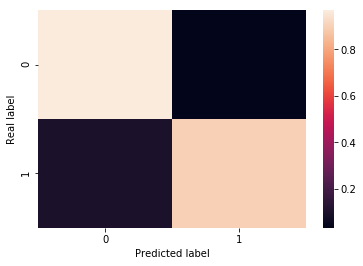

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat_norm)
plt.ylabel('Real label')
plt.xlabel('Predicted label')

In [19]:
from sklearn.metrics import f1_score, precision_score, recall_score
prec_scr = precision_score(y_test, y_test_pred, average='binary')
rec_scr = recall_score(y_test, y_test_pred, average='binary')
f1_scr = f1_score(y_test, y_test_pred, average='binary')
print('Precision: {}\nRecall: {}\nF1: {}'.format(prec_scr, rec_scr, f1_scr))

NameError: name 'y_test_pred' is not defined

### Results sum-up

The dataset is pretty small and because of this, results are identical.